In [2]:
import numpy as np
from deep_learning_models import *
from helper.dataset_reader import read_tsv
from helper.utils import *
import pandas as pd

In [3]:
print('Tensorflow version:', tf.__version__)
print('GPU detected:', tf.config.list_physical_devices('GPU'))
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

Tensorflow version: 2.8.0
GPU detected: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
merged_data = read_tsv('../../dataset/comlid-data-140422-v1.tsv')

train_data = read_tsv('../../dataset/train.tsv')
val_data = read_tsv('../../dataset/val.tsv')
test_data = read_tsv('../../dataset/test.tsv')

In [5]:
X_word_tr, X_char_tr, y_tr, idx_word_tr, idx_tag_tr = wc_input_converter(merged_data, train_data)
X_word_val, X_char_val, y_val, idx_word_val, idx_tag_val = wc_input_converter(merged_data, val_data)
X_word_ts, X_char_ts, y_ts, idx_word_ts, idx_tag_ts = wc_input_converter(merged_data, test_data)

In [6]:
df = list_to_dataframe(merged_data)

In [7]:
words = get_unique_words(df)
tags = get_unique_tags(df)
chars = set([w_i for w in words for w_i in w])

In [8]:
num_words = len(words)
num_tags = len(tags)
num_char = len(chars)
max_len = 100
max_len_char = 10

In [9]:
model = wc_cnn_blstm_model(num_words, num_tags, num_char, max_len, max_len_char)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 100, 10)]    0           []                               
                                                                                                  
 time_distributed (TimeDistribu  (None, 100, 10, 10)  5570       ['input_2[0][0]']                
 ted)                                                                                             
                                                                                                  
 dropout (Dropout)              (None, 100, 10, 10)  0           ['time_distributed[0][0]']       
                                                                                                  
 time_distributed_1 (TimeDistri  (None, 100, 10, 10)  310        ['dropout[0][0]']            

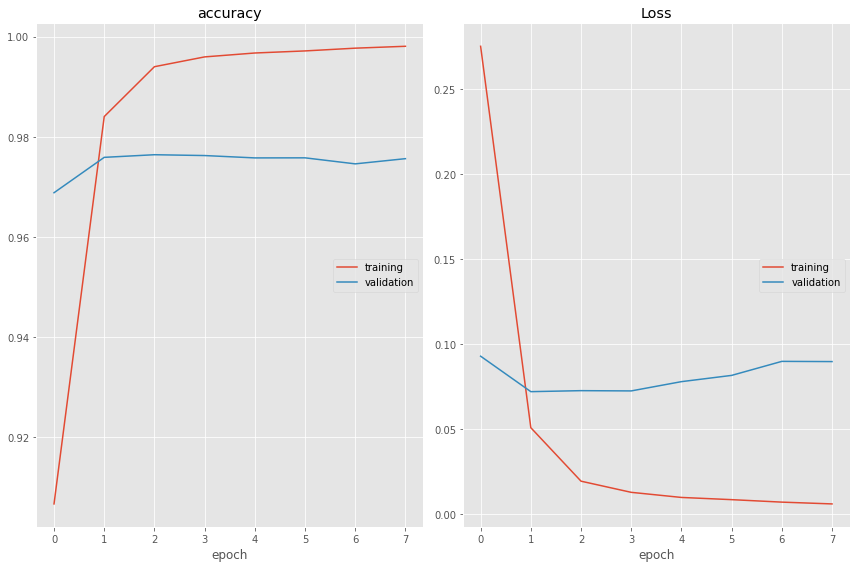

accuracy
	training         	 (min:    0.907, max:    0.998, cur:    0.998)
	validation       	 (min:    0.969, max:    0.976, cur:    0.976)
Loss
	training         	 (min:    0.006, max:    0.275, cur:    0.006)
	validation       	 (min:    0.072, max:    0.093, cur:    0.090)

Epoch 8: val_loss did not improve from 0.07199
91/91 [==============================] - 58s 636ms/step - loss: 0.0059 - accuracy: 0.9981 - val_loss: 0.0897 - val_accuracy: 0.9756


In [10]:
root_path = 'model/'
model_name = 'wc_cnn_blstm_model.h5'
num_epoch = 50
batch_sz = 32
callbacks = get_callbacks(root_path, model_name)

history = model.fit(x=[X_word_tr,
                     np.array(X_char_tr).reshape((len(X_char_tr), max_len, max_len_char))],
                    y=np.array(y_tr).reshape(len(y_tr), max_len, 1),
                    #validation_data=(X_word_val, y_val),
                    validation_data=(
                      [X_word_val, np.array(X_char_val).reshape((len(X_char_val),
                                                                max_len, max_len_char))],
                        np.array(y_val).reshape(len(y_val), max_len, 1)
                    ),
                    batch_size=batch_sz,
                    epochs=num_epoch,
                    callbacks=callbacks,
                    verbose=1
                    )

In [11]:
print(model.evaluate([X_word_ts, np.array(X_char_ts).reshape((len(X_char_ts), max_len, max_len_char))], np.array(y_ts).reshape(len(y_ts), max_len, 1)))

56/56 [==============================] - 5s 92ms/step - loss: 0.0858 - accuracy: 0.9768
[0.0858035609126091, 0.9768276214599609]


In [12]:
from keras.models import load_model

mdl = load_model('model/wc_cnn_blstm_model.h5')

In [13]:
predict_val = [X_word_ts, np.array(X_char_ts).reshape((len(X_char_ts), max_len, max_len_char))]

i = np.random.randint(0, X_word_ts.shape[0])
p = model.predict(predict_val)

p = np.argmax(p[i], axis=-1)
y_true = y_ts[i]
print("{:30}{:10}\t {}\n".format("Word", "True", "Pred"))
print("-" *60)

for w, true, pred in zip(X_word_ts[i], y_true, p):
    if w != 0:
        print("{:30}{:10}\t{}".format(idx_word_ts[w], idx_tag_ts[true], idx_tag_ts[pred]))

Word                          True      	 Pred

------------------------------------------------------------
oyi                           JV        	JV
rek                           JV        	JV
penjual                       ID        	ID
ayam                          ID        	ID
potong                        ID        	ID
di                            ID        	ID
pasar                         ID        	ID
itu                           ID        	ID
mau                           ID        	ID
apa                           ID        	ID
engga                         ID        	ID
ya                            ID        	ID
kalo                          ID        	ID
misal                         ID        	ID
kita                          ID        	ID
beline                        MIX-ID-JV 	MIX-ID-JV
fillet                        EN        	ID
?                             O         	O
spill                         EN        	EN
dipasar                       ID        	ID
mana 

In [14]:
all_w_pair = []
all_true_pair = []
all_pred_pair = []

for i in range(len(X_word_ts)):
    p = model.predict([X_word_ts,
                        np.array(X_char_ts).reshape((len(X_char_ts),
                                                     max_len, max_len_char))])
    p = np.argmax(p[i], axis=-1)
    y_true = y_ts[i]
    w_pair = []
    true_pair = []
    pred_pair = []
    for w, true, pred in zip(X_word_ts[i], y_true, p):
        if w != 0:
            print("{:30}{:10}\t{}".format(idx_word_ts[w], idx_tag_ts[true], idx_tag_ts[pred]))
            w_pair.append(idx_word_ts[w])
            true_pair.append(idx_tag_ts[true])
            pred_pair.append(idx_tag_ts[pred])
    all_w_pair.append(w_pair)
    all_true_pair.append(true_pair)
    all_pred_pair.append(pred_pair)

Cara                          ID        	ID
menghilangkan                 ID        	ID
ovt                           EN        	EN
gimana                        ID        	ID
:D                            O         	O
,                             O         	O
walau                         ID        	ID
udh                           ID        	ID
mule                          ID        	ID
teneg                         ID        	ID
tapi                          ID        	ID
ga                            ID        	ID
teneg                         ID        	ID
lagi                          ID        	ID
jadinya                       ID        	ID
(                             O         	O
harusnya                      ID        	ID
ke                            ID        	ID
priv                          EN        	ID
tapi                          ID        	ID
males                         ID        	ID
switch                        EN        	EN
acc                           EN   

In [15]:
true_flat = [item for sublist in all_true_pair for item in sublist]
pred_flat = [item for sublist in all_pred_pair for item in sublist]

              precision    recall  f1-score   support

          ID       0.91      0.96      0.93     22311
          JV       0.85      0.86      0.86      4914
          EN       0.87      0.84      0.86      5017
   MIX-ID-EN       0.97      0.83      0.89       973
   MIX-ID-JV       0.98      0.84      0.90       280
   MIX-JV-EN       0.94      0.85      0.90       277
           O       0.95      0.85      0.89     10152

   micro avg       0.91      0.91      0.91     43924
   macro avg       0.92      0.86      0.89     43924
weighted avg       0.91      0.91      0.91     43924



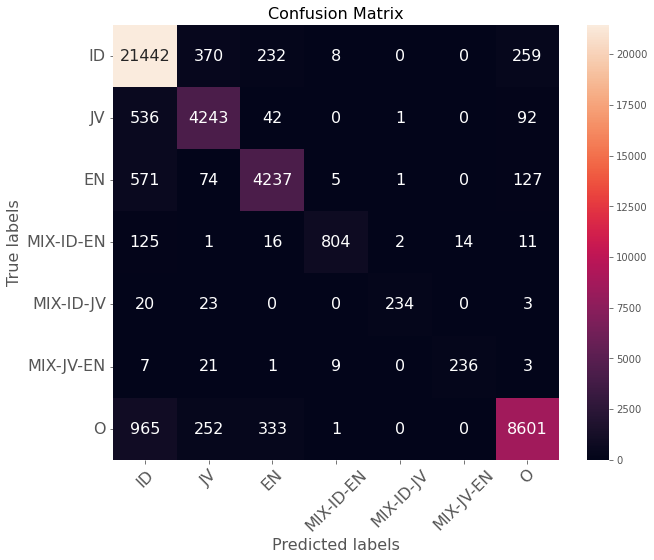

In [16]:
performance_report(true_flat, pred_flat)

In [17]:
df_ = pd.DataFrame({
    'word': all_w_pair,
    'true': all_true_pair,
    'pred': all_pred_pair
})

In [18]:
token_true_pred = []
for index, row in df_.iterrows():
    pair = list(zip(row['word'], row['true'], row['pred']))
    token_true_pred.append(pair)

In [19]:
true_pred_file = 'tagging_result/wc_cnn_blstm_compare_results.tsv'
with open(true_pred_file, "a", encoding='utf-8') as f:
    f.write("Word" + "\t" + "True" + "\t" + "Predict" + "\n")
    for index, row in df_.iterrows():
        for tkn, t_true, t_pred in (zip(row['word'], row['true'], row['pred'])):
            f.write(tkn + '\t' + t_true + '\t' + t_pred + '\n')
        f.write('\n')

f.close()